# Partial re-implementation of [Prior-aware autoencoders for lung pathology segmentation](https://www.sciencedirect.com/science/article/pii/S1361841522001384)

This paper is made up by 3 models:

1. a Partial Convolutionl Neural Network (PCNN) written as an autoencoder
2. a Normal Appearance Autoencoder model (NAA)
3. the Prior UNet which predicts the lung pathology segmentation mask.

This notebook will implement 2 and 3 the same way as the paper, but will the [Semantic Diffusion Model](https://github.com/WeilunWang/semantic-diffusion-model) instead for 1.

In [1]:
!pip install torch numpy Pillow torchsummary torchvision matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
import tqdm
import torch.nn.functional as F

## Module 1: Semantic Diffusion Model

The diffusion model has been trained and should be able to perform inference using the /scripts/luna16.sh script in the SDM folder.
Here, we only prepare the dataset that can be used to train the NAA model.

In [3]:
# Directly inference from the trained SDM model to generate pathlogy free images
# by running the /scripts/luna16.sh under the Semantic Diffusion Model directory

# Prepare training and test dataset
LESION_PATH = "/home/user/data/gt/"
# LESION_FREE_PATH = "/home/user/data/prior_train/lesion-free"
LESION_FREE_PATH = "/home/user/data/inpainted/"
WEIGHT_MAP_PATH = "/home/user/luna-16-seg-diff-data/nodule_labels_ohe/"

class NAAImageDataset(Dataset):
  def __init__(self, lesion_path, lesion_free_path, weight_map_path):
    self.lesion_path = lesion_path
    self.lesion_free_path = lesion_free_path
    self.weight_map_path = weight_map_path
    self.file_list = os.listdir(self.lesion_path)
  
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, idx):
    filename = self.file_list[idx]
    lesion_image = Image.open(os.path.join(self.lesion_path, filename))
    lesion_free_image = Image.open(os.path.join(self.lesion_free_path, filename))
    
    lesion_image = lesion_image.convert('L')
    lesion_free_image = lesion_free_image.convert('L')
    
    weight_map = Image.open(os.path.join(self.weight_map_path, filename[:-4]))
    weight_map = weight_map.resize((256, 256))
    weight_map = weight_map.convert('L')
    # Convert the grayscale image to a NumPy array
    grayscale_array = np.array(weight_map)
    mask = grayscale_array > 0
    converted_array = np.where(mask, 2, 0)
    
    # Create a new image from the converted array
    # converted_image = Image.fromarray(converted_array.astype(np.uint8))
    
    return transforms.ToTensor()(lesion_image) * 255, transforms.ToTensor()(lesion_free_image) * 255, transforms.ToTensor()(converted_array)

In [4]:
dataset = NAAImageDataset(LESION_PATH, LESION_FREE_PATH, WEIGHT_MAP_PATH)

# randomly split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Module 2: Normal Appearance Autoencoder

In [34]:
# Define the Normal Apperance Autoencoder (NAA). It consists of an input layer of size 512, 5 hidden layers of size 256, 128, 64, 64, 64 and a sampling layer for mean and logvar of size 64
# Define a convolution layer where each conv block consists of a conv2d layer, a batchnorm layer, then another conv2d layer followed by another batch normalization layer and finally a relu layer
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True, max_pool=True):
        super(ConvBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        self.maxpool = nn.MaxPool2d(2, 2) if max_pool else None
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.layers(x)
        if self.maxpool is not None:
            x = self.maxpool(x)
        x = self.dropout(x)
        return x


class NAA(nn.Module):
    def __init__(self):
        super(NAA, self).__init__()
        self.encoder = torch.nn.Sequential(
            ConvBlock(1, 8, kernel_size=3),
            ConvBlock(8, 16, kernel_size=3),
            ConvBlock(16, 32, kernel_size=3, max_pool=False),
            ConvBlock(32, 64, kernel_size=3, max_pool=False),
            ConvBlock(64, 128, kernel_size=3, max_pool=False),
        )
        self.mean = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.logvar = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.mean_relu = nn.ReLU()
        self.logvar_relu = nn.ReLU()
        
        # few layers are commented out for experimental reasons
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=6, stride=4, padding=1),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            # ConvBlock(64, 64, kernel_size=3, max_pool=False),
            # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            # ConvBlock(32, 32, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            # ConvBlock(16, 16, kernel_size=3, max_pool=False),
            # nn.ConvTranspose2d(16, 8, kernel_size=3, stride=1, padding=1),
            # nn.LeakyReLU(),
            # nn.Dropout(0.2),
            # ConvBlock(8, 8, kernel_size=3, max_pool=False),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(1, 1, kernel_size=1),
            nn.Sigmoid()
        )
        # self.final = nn.Sequential(
        #     nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0),
        #     nn.Sigmoid()
        # )

    def reparameterize(self, mean, logvar):
        # if self.training:
        # print(logvar.max(), logvar.min())
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
        # else:
        #     return mean
        
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        x = self.encoder(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        x = self.decoder(z)
        return x, mean, logvar

In [35]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NAA().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
summary(model, input_size=(1, 256, 256))

import gc
model = model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

Total number of parameters is: 740939
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]              80
       BatchNorm2d-2          [-1, 8, 256, 256]              16
         LeakyReLU-3          [-1, 8, 256, 256]               0
            Conv2d-4          [-1, 8, 256, 256]             584
       BatchNorm2d-5          [-1, 8, 256, 256]              16
         LeakyReLU-6          [-1, 8, 256, 256]               0
         MaxPool2d-7          [-1, 8, 128, 128]               0
           Dropout-8          [-1, 8, 128, 128]               0
         ConvBlock-9          [-1, 8, 128, 128]               0
           Conv2d-10         [-1, 16, 128, 128]           1,168
      BatchNorm2d-11         [-1, 16, 128, 128]              32
        LeakyReLU-12         [-1, 16, 128, 128]               0
           Conv2d-13         [-1, 16, 128, 128]           2,320
 

In [38]:
from torch.optim.lr_scheduler import ExponentialLR

model = NAA().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.8)
num_epochs = 40

def loss_function(recon_x, input, target, mu, logvar, weight_map):  
  alpha = 0.0001 # as suggested by the paper
  REC = F.mse_loss(recon_x, target, reduction='none') * weight_map
  REC = REC.view(REC.size(0), -1).mean()
  REG = alpha * F.mse_loss(model.encode(input), model.encode(target), reduction='none')
  REG = REG.view(REG.size(0), -1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return REC + REG + KLD, REC, REG, KLD

print("Training begins!")

for epoch in range(num_epochs):
  model.train()
  print(f"Epoch {epoch} begins:")
  with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      weight_map = weight_map.to(device)
      optimizer.zero_grad()
      recon, mu, logvar = model(lesion)
      loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
      loss.backward()
      optimizer.step()
      
      if batch_idx % 20 == 0:
        tepoch.set_description(f"Epoch {epoch} / {num_epochs}, batch {batch_idx}, Loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")
        tepoch.set_postfix(loss=loss.item()/len(lesion))
    scheduler.step()

  model.eval()
  
  with torch.no_grad():
    with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
      for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
        lesion = lesion.to(device)
        lesion_free = lesion_free.to(device)
        weight_map = weight_map.to(device)
        recon, mu, logvar = model(lesion)
        loss, rec, reg, kld = loss_function(recon, lesion, lesion_free, mu, logvar, weight_map)
        if batch_idx % 20 == 0:
          tepoch.set_description(f"Validation loss: {loss / len(lesion)}, REC: {rec / len(lesion)}, REG: {reg / len(lesion)}, KLD: {kld / len(lesion)}")


Training begins!
Epoch 0 begins:


Epoch 0 / 40, batch 20, Loss: 5896.42919921875, REC: 789.004150390625, REG: 6.297527477272524e-08, KLD: 1951.408447265625: 100%|██████████| 29/29 [00:07<00:00,  3.94batch/s, loss=5.9e+3] 
Validation loss: 4402.43798828125, REC: 786.3385009765625, REG: 3.5462768832594804e-10, KLD: 470.74560546875: 100%|██████████| 8/8 [00:01<00:00,  4.58batch/s]


Epoch 1 begins:


Epoch 1 / 40, batch 20, Loss: 4325.97314453125, REC: 783.0318603515625, REG: 2.6780210049537345e-08, KLD: 410.8139953613281: 100%|██████████| 29/29 [00:07<00:00,  4.01batch/s, loss=4.33e+3]
Validation loss: 3898.38232421875, REC: 769.542236328125, REG: 2.3379195801531694e-10, KLD: 50.67121124267578: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 2 begins:


Epoch 2 / 40, batch 20, Loss: 4278.904296875, REC: 813.168212890625, REG: 2.0748966989003748e-08, KLD: 213.06298828125: 100%|██████████| 29/29 [00:07<00:00,  3.96batch/s, loss=4.28e+3]    
Validation loss: 4098.2607421875, REC: 817.378662109375, REG: 3.318223820714117e-11, KLD: 11.36762809753418: 100%|██████████| 8/8 [00:01<00:00,  4.61batch/s]


Epoch 3 begins:


Epoch 3 / 40, batch 20, Loss: 4263.576171875, REC: 821.4927978515625, REG: 1.778351688130897e-08, KLD: 156.11228942871094: 100%|██████████| 29/29 [00:07<00:00,  3.96batch/s, loss=4.26e+3]
Validation loss: 3815.441162109375, REC: 760.7996826171875, REG: 3.07025030399366e-11, KLD: 11.442562103271484: 100%|██████████| 8/8 [00:01<00:00,  4.77batch/s]


Epoch 4 begins:


Epoch 4 / 40, batch 20, Loss: 4288.060546875, REC: 834.211181640625, REG: 1.6307021510897357e-08, KLD: 117.00480651855469: 100%|██████████| 29/29 [00:08<00:00,  3.53batch/s, loss=4.29e+3]
Validation loss: 4213.00927734375, REC: 839.0223388671875, REG: 9.675628354077759e-11, KLD: 17.89729118347168: 100%|██████████| 8/8 [00:01<00:00,  4.60batch/s]


Epoch 5 begins:


Epoch 5 / 40, batch 20, Loss: 4189.72509765625, REC: 809.849609375, REG: 1.965411655646676e-08, KLD: 140.47723388671875: 100%|██████████| 29/29 [00:08<00:00,  3.29batch/s, loss=4.19e+3]
Validation loss: 4270.6337890625, REC: 852.013916015625, REG: 7.079292013711935e-11, KLD: 10.564360618591309: 100%|██████████| 8/8 [00:02<00:00,  2.90batch/s]


Epoch 6 begins:


Epoch 6 / 40, batch 20, Loss: 4134.88232421875, REC: 808.9677734375, REG: 1.5789202834071148e-08, KLD: 90.04330444335938: 100%|██████████| 29/29 [00:07<00:00,  3.69batch/s, loss=4.13e+3] 
Validation loss: 4012.94287109375, REC: 798.9180908203125, REG: 2.0141946444063308e-10, KLD: 18.35244369506836: 100%|██████████| 8/8 [00:01<00:00,  4.46batch/s]


Epoch 7 begins:


Epoch 7 / 40, batch 20, Loss: 4430.63916015625, REC: 864.9932861328125, REG: 1.654105830084518e-08, KLD: 105.6727294921875: 100%|██████████| 29/29 [00:07<00:00,  3.91batch/s, loss=4.43e+3]
Validation loss: 3853.95556640625, REC: 767.894775390625, REG: 2.3231741530516103e-10, KLD: 14.481700897216797: 100%|██████████| 8/8 [00:01<00:00,  4.72batch/s]


Epoch 8 begins:


Epoch 8 / 40, batch 20, Loss: 4241.0029296875, REC: 835.5567016601562, REG: 1.858844811408744e-08, KLD: 63.21929168701172: 100%|██████████| 29/29 [00:07<00:00,  3.98batch/s, loss=4.24e+3]
Validation loss: 4061.482666015625, REC: 810.9969482421875, REG: 3.3768248614007845e-11, KLD: 6.497707366943359: 100%|██████████| 8/8 [00:01<00:00,  4.58batch/s]


Epoch 9 begins:


Epoch 9 / 40, batch 20, Loss: 4201.634765625, REC: 824.1740112304688, REG: 1.6037978056715474e-08, KLD: 80.76481628417969: 100%|██████████| 29/29 [00:07<00:00,  3.96batch/s, loss=4.2e+3]   
Validation loss: 3973.375732421875, REC: 791.8419189453125, REG: 1.4595308295284326e-10, KLD: 14.16629409790039: 100%|██████████| 8/8 [00:01<00:00,  4.64batch/s]


Epoch 10 begins:


Epoch 10 / 40, batch 20, Loss: 4063.02001953125, REC: 803.7740478515625, REG: 1.4676030168914167e-08, KLD: 44.14994812011719: 100%|██████████| 29/29 [00:07<00:00,  3.93batch/s, loss=4.06e+3]
Validation loss: 4159.2880859375, REC: 828.3285522460938, REG: 7.848203198435044e-10, KLD: 17.645294189453125: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 11 begins:


Epoch 11 / 40, batch 20, Loss: 3922.575439453125, REC: 775.7539672851562, REG: 1.5237342054774672e-08, KLD: 43.80570602416992: 100%|██████████| 29/29 [00:07<00:00,  4.00batch/s, loss=3.92e+3]
Validation loss: 3806.13427734375, REC: 757.9674072265625, REG: 2.6016466758704837e-10, KLD: 16.29730796813965: 100%|██████████| 8/8 [00:01<00:00,  4.73batch/s]


Epoch 12 begins:


Epoch 12 / 40, batch 20, Loss: 4033.594970703125, REC: 798.1910400390625, REG: 1.390683479485233e-08, KLD: 42.639808654785156: 100%|██████████| 29/29 [00:07<00:00,  4.01batch/s, loss=4.03e+3]
Validation loss: 3980.962890625, REC: 794.3492431640625, REG: 1.2688380901515472e-10, KLD: 9.216850280761719: 100%|██████████| 8/8 [00:01<00:00,  4.58batch/s]


Epoch 13 begins:


Epoch 13 / 40, batch 20, Loss: 4208.4365234375, REC: 832.2374267578125, REG: 1.5875732728432013e-08, KLD: 47.249332427978516: 100%|██████████| 29/29 [00:07<00:00,  3.95batch/s, loss=4.21e+3]
Validation loss: 4018.93798828125, REC: 801.913330078125, REG: 5.272852987570076e-11, KLD: 9.371330261230469: 100%|██████████| 8/8 [00:01<00:00,  4.47batch/s]


Epoch 14 begins:


Epoch 14 / 40, batch 20, Loss: 4088.96142578125, REC: 808.414306640625, REG: 1.466328569676989e-08, KLD: 46.88983917236328: 100%|██████████| 29/29 [00:07<00:00,  4.02batch/s, loss=4.09e+3]
Validation loss: 4127.00830078125, REC: 823.01123046875, REG: 2.601641957422629e-10, KLD: 11.951995849609375: 100%|██████████| 8/8 [00:01<00:00,  4.57batch/s]


Epoch 15 begins:


Epoch 15 / 40, batch 20, Loss: 4280.2099609375, REC: 841.21826171875, REG: 1.723877929293849e-08, KLD: 74.11880493164062: 100%|██████████| 29/29 [00:07<00:00,  4.00batch/s, loss=4.28e+3]
Validation loss: 4063.0224609375, REC: 809.772216796875, REG: 4.5147507954368393e-10, KLD: 14.161333084106445: 100%|██████████| 8/8 [00:01<00:00,  4.65batch/s]


Epoch 16 begins:


Epoch 16 / 40, batch 20, Loss: 4448.91552734375, REC: 872.107666015625, REG: 1.8394162637491718e-08, KLD: 88.37734985351562: 100%|██████████| 29/29 [00:07<00:00,  4.00batch/s, loss=4.45e+3]
Validation loss: 4089.56640625, REC: 816.4989624023438, REG: 7.337894875059092e-11, KLD: 7.071563720703125: 100%|██████████| 8/8 [00:01<00:00,  4.70batch/s]


Epoch 17 begins:


Epoch 17 / 40, batch 0, Loss: 3975.963623046875, REC: 785.2691040039062, REG: 1.6220267795574728e-08, KLD: 49.61817932128906:  52%|█████▏    | 15/29 [00:04<00:03,  3.71batch/s, loss=3.98e+3]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, weight_map) in enumerate(tepoch):
      print(weight_map.min(), weight_map.max())
      print(lesion.max(), lesion.min())
      print(lesion_free.max(), lesion_free.min())
      break

  0%|          | 0/8 [00:00<?, ?batch/s]

tensor(0) tensor(2)
tensor(255.) tensor(0.)
tensor(255.) tensor(0.)


Validation loss: 4242.36767578125:   0%|          | 0/8 [00:00<?, ?batch/s]

0.0 255.0
0.0 255.0
0.617894 1.0099621


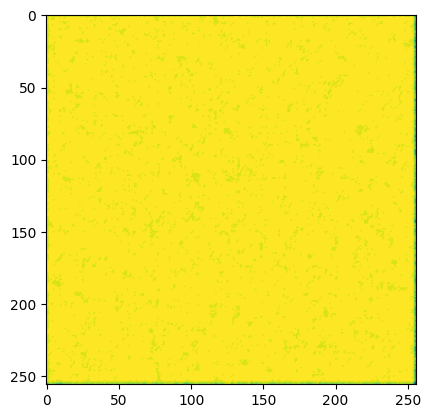

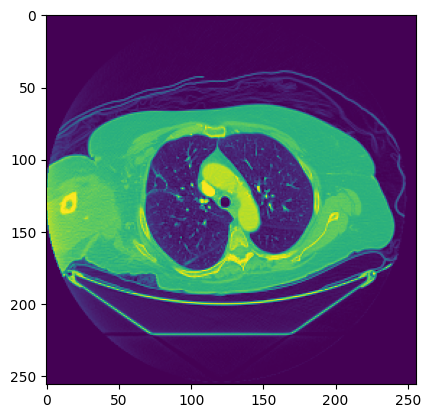

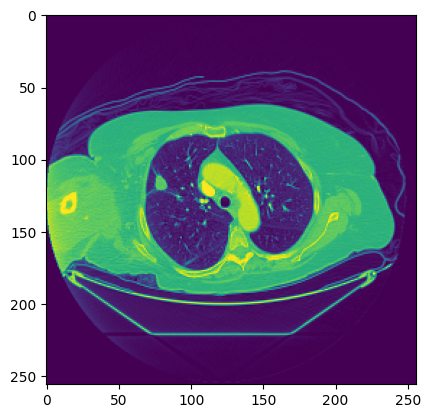

Validation loss: 4242.36767578125:   0%|          | 0/8 [00:00<?, ?batch/s]


: 

In [41]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        recon = recon[0][0].cpu().numpy()
        # The next 3 lines is to make the small value smaller and big value bigger
        # big_scale = 1.01
        # small_scale = 0.99
        # recon = np.where(recon > recon.mean(), recon * big_scale, recon * small_scale)
        print(lesion_free[0][0].cpu().numpy().min(), lesion_free[0][0].cpu().numpy().max())
        print(lesion[0][0].cpu().numpy().min(), lesion[0][0].cpu().numpy().max())
        print(recon.min(), recon.max())
        plt.imshow(recon)
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

Validation loss: 663.0842895507812:   0%|          | 0/8 [00:00<?, ?batch/s]

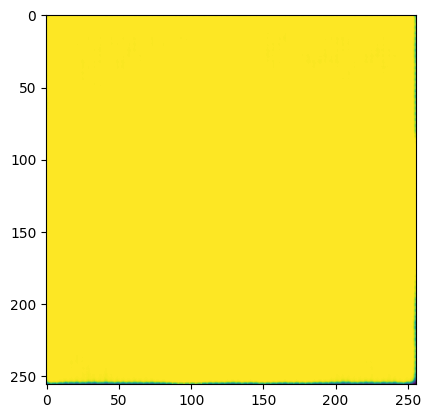

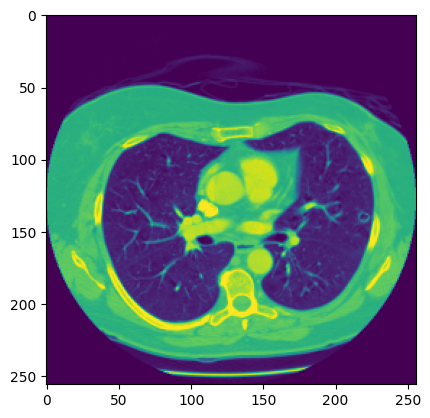

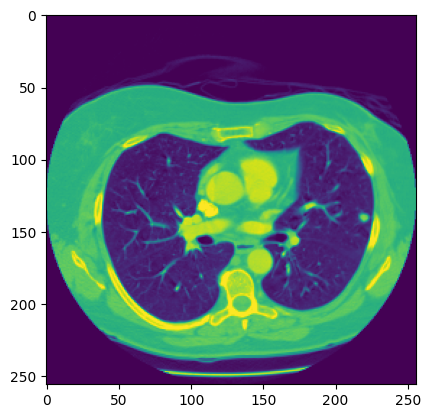

Validation loss: 663.0842895507812:   0%|          | 0/8 [00:00<?, ?batch/s]


In [ ]:
import matplotlib.pyplot as plt

model.eval()

with torch.no_grad():
  with tqdm.tqdm(test_dataloader, unit="batch") as tepoch:
    for batch_idx, (lesion, lesion_free, _) in enumerate(tepoch):
      lesion = lesion.to(device)
      lesion_free = lesion_free.to(device)
      recon, mu, logvar = model(lesion)
      if batch_idx % 10 == 0:
        tepoch.set_description(f"Validation loss: {loss / len(lesion)}")
        plt.imshow(recon[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion_free[0][0].cpu().numpy())
        plt.show()
        plt.imshow(lesion[0][0].cpu().numpy())
        plt.show()
        break

## Module 3: Prior UNet